In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import time
import sys
import time
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from scipy.optimize import rosen
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ['CUDA_MPS_PIPE_DIRECTORY'] = "/tmp/nvidia-mps"
os.environ['CUDA_MPS_LOG_DIRECTORY'] = "/tmp/nvidia-log"

In [3]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def get_errors(x_, y_): # return rmse, mae, maxae
    x_ = x_.squeeze()
    y_ = y_.squeeze()
    return [np.sqrt(mse(x_, y_)), np.mean(np.abs(x_ - y_)), np.max(np.abs(x_ - y_))]

def get_mcdues_nn(X, sess, y, x, keep_probability_, p = .5, T=100): # returns MCD UEs
    stds = np.zeros((X.shape[0], T), dtype = float)
    for cnt_ in range(T):
        stds[:, cnt_] = np.ravel(sess.run(y, feed_dict={x: X, 
                                                        keep_probability_: p}))
    return np.std(stds, axis = 1)

In [4]:
def random_sampling(X_pool, y_pool, points_to_sample):
    random_indices = np.random.permutation(X_pool.shape[0])[:points_to_sample]
    X_sample = X_pool[random_indices, :]
    y_sample = y_pool[random_indices, :]
#     X_pool = np.delete(X_pool, random_indices, 0)
#     y_pool = np.delete(y_pool, random_indices, 0)
    
    return X_pool, y_pool, X_sample, y_sample

def GMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample): # greedy (classic) MCDUE
    mcd_indices = np.argsort(get_mcdues_nn(X_pool, sess, y, x, keep_probability_))[-points_to_sample:]
    X_sample = X_pool[mcd_indices, :]
    y_sample = y_pool[mcd_indices, :]
#     X_pool = np.delete(X_pool, mcd_indices, 0)
#     y_pool = np.delete(y_pool, mcd_indices, 0)
    
    return X_pool, y_pool, X_sample, y_sample, mcd_indices

def DMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample): # Distribution MCDUE
    mcds = get_mcdues_nn(X_pool, sess, y, x, keep_probability_) 
    log_mcds = np.ma.log(mcds).filled(0)
    x_dist = sns.distplot(log_mcds).get_lines()[0].get_data()[0];
    y_dist = sns.distplot(log_mcds).get_lines()[0].get_data()[1];
    derivatives = np.empty(x_dist.shape[0] - 1)
    for i in range(derivatives.shape[0]):
        derivatives[i] = (y_dist[i + 1] - y_dist[i]) / (x_dist[i + 1] - x_dist[i])
    tmp_der = derivatives
    threshold = 1 # Threshold for derivative
    derivatives[abs(derivatives) < threshold] = 0
    while((derivatives==np.zeros(derivatives.shape[0])).sum() >= derivatives.shape[0] - 1): # If threshold is too high
        derivatives = tmp_der
        threshold *= 0.9
        derivatives[abs(derivatives) < threshold] = 0       
        
    last_point = np.where(derivatives < 0)[0][-1] + 1
    ind_where = np.argwhere(log_mcds <= x_dist[last_point]).squeeze()
    indices = np.argsort(mcds[ind_where])
    
    indices = ind_where[indices][-points_to_sample:]
    
    X_sample = X_pool[indices, :]
    y_sample = y_pool[indices, :]
#     X_pool = np.delete(X_pool, indices, 0)
#     y_pool = np.delete(y_pool, indices, 0)
    
    return X_pool, y_pool, X_sample, y_sample, indices

In [5]:
def train_nn(X_tr, y_tr, sess, y, y_, x, l2_reg_, keep_probability_, kp, saver,
             train_step, loss, init_epochs, batch_size, X_test=None, y_test=None):

    print('pos 1')
    if(not type(kp)==type([])):
        keeps = [kp]
    else:
        keeps = kp
    current_error = 1e+10
    patience = 0
    for keep_prob in keeps:
        for cnt in range(init_epochs):
            for batch in iterate_minibatches(X_tr, y_tr, batch_size):
                X_batch, y_batch = batch
                sess.run(train_step, feed_dict={x: X_batch, 
                                                y_: y_batch, 
                                                keep_probability_: keep_prob, 
                                                l2_reg_: 1e-5})
            if cnt % 100 == 0:
                preds_train = sess.run(y, feed_dict= {x: X_tr , keep_probability_: 1})
                train_err = get_errors(preds_train.squeeze(), y_tr.squeeze())[0]
                print(train_err)
                if train_err > current_error:
                    patience += 1
                if patience > 2:
                    print(f'Early stopping in epoch {cnt}')
                    break
                current_error = train_err
                
    print('pos 2')
        
    if(X_test is not None): # estimate error on test
        preds_train = sess.run(y, feed_dict= {x: X_tr , keep_probability_: 1})
        preds_test = sess.run(y, feed_dict= {x: X_test , keep_probability_: 1})
        test_err =  get_errors(preds_test.squeeze(), y_test.squeeze())
        train_err = get_errors(preds_train.squeeze(), y_tr.squeeze())
        return test_err, train_err
    else:
        return

In [6]:
def create_model(X_train, y_train, layers, path, lr, keeps_train, init_epochs_train, batch_size_train):
    # Creates and trains a model on training set and saves it
    
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, [None, ndim], name='x')
    y_ = tf.placeholder(tf.float32, [None, 1], name='true_answers')

    learning_rate_ = tf.placeholder(tf.float32)
    forces_coeff_ = tf.placeholder(tf.float32)
    keep_probability_ = tf.placeholder(tf.float32, name='keep_probability')
    l2_reg_ = tf.placeholder(tf.float32, name='l2reg')

    initializer = tf.contrib.layers.xavier_initializer()
    W1 = tf.Variable(initializer((ndim, layers[0])))
    b1 = tf.Variable(initializer((layers[0],)))
    h1 = tf.nn.leaky_relu(tf.matmul(x, W1) + b1, alpha=0.01)

    h_drop1 = tf.nn.dropout(h1, keep_probability_, noise_shape = [1,layers[0]])

    Ws = [W1]; bs = [b1]; hs = [h_drop1]
    for cnt_layer in range(1, len(layers)):
        Ws.append(tf.Variable(initializer((layers[cnt_layer - 1], layers[cnt_layer])), name='weights'))
        bs.append(tf.Variable(initializer((layers[cnt_layer],)), name='biases'))
        hs.append(tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(hs[-1], Ws[-1]) + bs[-1], alpha=0.01, name='leaky_relu_activations'), keep_probability_,
                                noise_shape = [1,layers[cnt_layer]]))


    Ws.append(tf.Variable(initializer((layers[-1], 1)), name='weights'))
    bs.append(tf.Variable(initializer((1,)), name='biases'))
    # funcs
    y = tf.matmul(hs[-1], Ws[-1]) + bs[-1]

    l2_regularizer = sum(tf.nn.l2_loss(Wxxx) for Wxxx in Ws) 

    mse_e = tf.losses.mean_squared_error(predictions = y, labels = y_)
    loss = mse_e + l2_reg_*l2_regularizer

    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

    try:
        sess.close()
    except:
        pass

    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session(config=config)
    sess.run(init)
    train_nn(X_train, y_train, sess, y, y_, x, l2_reg_, keep_probability_, keeps_train, saver, train_step, loss, init_epochs_train, batch_size_train)
    save_path = saver.save(sess, path) # Saves the model
    print('model is saved: ', save_path)

In [7]:
def model_loader(layers,  path, lr): # Load a model of a particular architecture
    tf.reset_default_graph()
    
    x = tf.placeholder(tf.float32, [None, ndim], name='x')
    y_ = tf.placeholder(tf.float32, [None, 1], name='true_answers')

    learning_rate_ = tf.placeholder(tf.float32)
    forces_coeff_ = tf.placeholder(tf.float32)
    keep_probability_ = tf.placeholder(tf.float32, name='keep_probability')
    l2_reg_ = tf.placeholder(tf.float32, name='l2reg')

    initializer = tf.contrib.layers.xavier_initializer()
    W1 = tf.Variable(initializer((ndim, layers[0])))
    b1 = tf.Variable(initializer((layers[0],)))
    h1 = tf.nn.leaky_relu(tf.matmul(x, W1) + b1, alpha=0.01)

    h_drop1 = tf.nn.dropout(h1, keep_probability_, noise_shape = [1,layers[0]])

    Ws = [W1]; bs = [b1]; hs = [h_drop1]
    for cnt_layer in range(1, len(layers)):
        Ws.append(tf.Variable(initializer((layers[cnt_layer - 1], layers[cnt_layer])), name='weights'))
        bs.append(tf.Variable(initializer((layers[cnt_layer],)), name='biases'))
        hs.append(tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(hs[-1], Ws[-1]) + bs[-1], alpha=0.01, name='leaky_relu_activations'), keep_probability_,
                                noise_shape = [1,layers[cnt_layer]]))


    Ws.append(tf.Variable(initializer((layers[-1], 1)), name='weights'))
    bs.append(tf.Variable(initializer((1,)), name='biases'))
    # funcs
    y = tf.matmul(hs[-1], Ws[-1]) + bs[-1]

    l2_regularizer = sum(tf.nn.l2_loss(Wxxx) for Wxxx in Ws) 

    mse_e = tf.losses.mean_squared_error(predictions = y, labels = y_)

    loss = mse_e + l2_reg_*l2_regularizer

    train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

    try:
        sess.close()
    except:
        pass

    config = tf.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth = True

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session(config=config)
    sess.run(init)
    
    saver = tf.train.Saver()
    saver.restore(sess, path) # Loading
    
    return sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss

In [8]:
def generate_data(size, d, pool_share=0.6, rs=[322228, 1337410, 2033007], upper_border=4):
    
    random_state = rs[0]
    np.random.seed(random_state)
    
    # Pool
    pool_shape = int(size * pool_share)
    randmat = np.random.uniform(size = d * pool_shape).reshape(pool_shape, d) * upper_border # random from [0, 10]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_pool = df.values
    y_pool = targets[:, None]
    
    random_state = rs[1]
    np.random.seed(random_state)
    
    # Test
    train_test_shape = int(size * (1 - pool_share) / 2)
    randmat = np.random.uniform(size = d * train_test_shape).reshape(train_test_shape, d) * upper_border # random from [0, 1]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_test = df.values
    y_test = targets[:, None]
    
    
    random_state = rs[2]
    np.random.seed(random_state)
    # Train
    train_test_shape = int(size * (1 - pool_share) / 2)
    randmat = np.random.uniform(size = d * train_test_shape).reshape(train_test_shape, d) * upper_border # random from [0, 1]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_train = df.values
    y_train = targets[:, None]

    print('Train shapes:', X_train.shape, y_train.shape)
    print('Test shapes:', X_test.shape, y_train.shape)
    print('Pool shapes:', X_pool.shape, y_pool.shape)
    return X_train, y_train, X_test, y_test, X_pool, y_pool

In [9]:
def generate_data_outsample(size, d, pool_share=0.6, rs=[322228, 1337410, 2033007], upper_border=4):
    
    random_state = rs[0]
    np.random.seed(random_state)
    
    # Pool
    pool_shape = int(size * pool_share)
    randmat = np.random.uniform(size = d * pool_shape).reshape(pool_shape, d) * upper_border # random from [0, 10]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_pool = df.values
    y_pool = targets[:, None]
    
    random_state = rs[1]
    np.random.seed(random_state)
    
    # Test
    train_test_shape = int(size * (1 - pool_share) / 2)
    randmat = np.random.uniform(size = d * train_test_shape).reshape(train_test_shape, d) * upper_border # random from [0, 1]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_test = df.values
    y_test = targets[:, None]
    
    
    random_state = rs[2]
    np.random.seed(random_state)
    # Train
    train_test_shape = int(size * (1 - pool_share) / 2)
    randmat = np.random.uniform(size = d * train_test_shape).reshape(train_test_shape, d) * (upper_border // 2) # random from [0, 1]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_train = df.values
    y_train = targets[:, None]

    print('Train shapes:', X_train.shape, y_train.shape)
    print('Test shapes:', X_test.shape, y_train.shape)
    print('Pool shapes:', X_pool.shape, y_pool.shape)
    return X_train, y_train, X_test, y_test, X_pool, y_pool

In [10]:
# Parameters for the NN

size = 20000 # size of Rosenbrock dataset
dimensionality = 5 # dimentionality of Rosenbrock
upper_border = 4
layers = [256, 128, 128, 64]

points_to_sample = 2000

In [11]:
X_train, y_train, X_test, y_test, X_pool, y_pool = generate_data_outsample(size, dimensionality, pool_share=0.6, upper_border=4)

Train shapes: (4000, 5) (4000, 1)
Test shapes: (4000, 5) (4000, 1)
Pool shapes: (12000, 5) (12000, 1)


In [12]:

lr = 1e-3
keeps_train = [.95]
init_epochs_train = 10000 # Number of epoches for training
batch_size_train = 1000 # Training batchsize
ndim = dimensionality
path = './{}/model_{}.ckpt'.format(len(layers), len(layers))

In [13]:
create_model(X_train, y_train, layers, path, lr, keeps_train, init_epochs_train, batch_size_train)
sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss = model_loader(layers,  path, lr)

pos 1
899.7535204733312
278.9904728929722
127.04562414567182
97.49332080567983
84.98186681202559
71.06747912235288
61.449085733563315
77.98270643393938
65.14243211814632
45.027385447688474
48.67167881838613
75.30120014194381
Early stopping in epoch 1100
pos 2
model is saved:  ./4/model_4.ckpt
INFO:tensorflow:Restoring parameters from ./4/model_4.ckpt


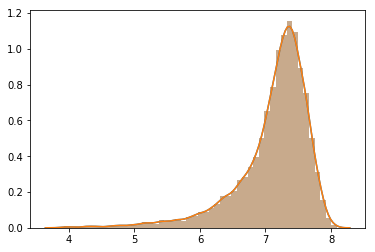

In [14]:
_, _, X_sample, y_sample, indices_dmcdue = DMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample)
_, _, X_sample, y_sample, indices_mcdue = GMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample)

### 1. Points, which are similar to training dataset in terms of all coordinates

We create a random matrix for Rosenbrock function, entries of which are within [0, upper_bound] for Pool and Test, but  [0, upper_bound // 2] for Train. 

Then we plot them all:

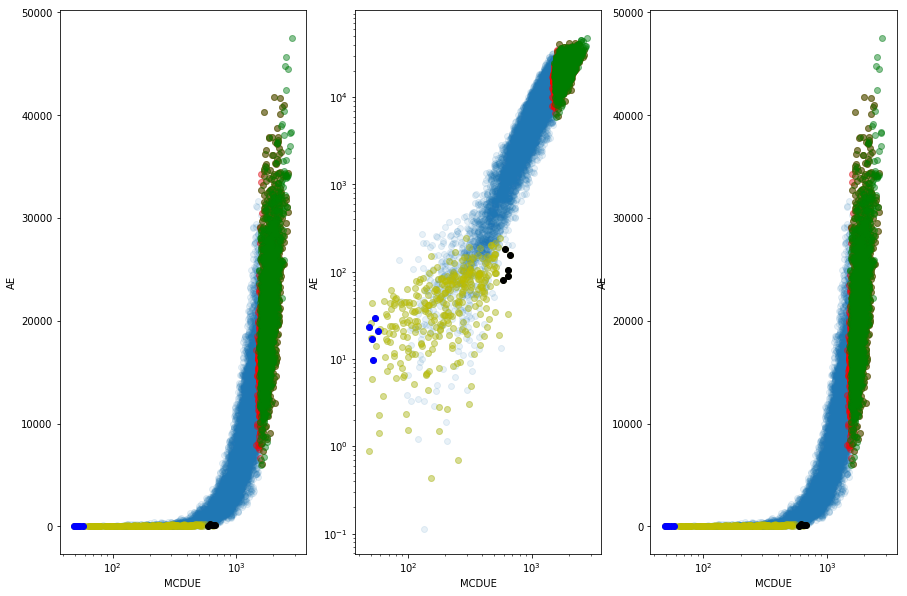

In [15]:
in_sample_ind = np.where(np.max(X_pool, axis=1) <= upper_border // 2)[0].squeeze() # points, which are in the same subset
# argmin_in_sample = 
# as Training points
pred_pool = sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}) # Pool prediction
argmin_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[:5]]
argmax_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[-5:]]
mcdues = get_mcdues_nn(X_pool, sess, y, x, keep_probability_, p = .5, T=100)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
for i in [0, 1, 2]:
    if(i==1):
        ax[i].set_yscale('log')
    if(i==0 or i==1):    
        ax[i].set_xscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel('MCDUE')
    ax[i].set_ylabel('AE')
    ax[i].scatter(mcdues, np.abs(y_pool - pred_pool), alpha=0.1) # Pool points
    ax[i].scatter(mcdues[in_sample_ind],  np.abs(y_pool - pred_pool)[in_sample_ind], c='y', alpha=0.4)
    ax[i].scatter(mcdues[indices_dmcdue], np.abs(y_pool - pred_pool)[indices_dmcdue], c='r', alpha=0.4)
    ax[i].scatter(mcdues[indices_mcdue], np.abs(y_pool - pred_pool)[indices_mcdue], c='g', alpha=0.4)
    ax[i].scatter(mcdues[argmin_in_sample],  np.abs(y_pool - pred_pool)[argmin_in_sample], c='b', alpha=1.)
    ax[i].scatter(mcdues[argmax_in_sample],  np.abs(y_pool - pred_pool)[argmax_in_sample], c='k', alpha=1.)

Here Green points are MCDUE sampled, Red -- DMCDUE sampled, Yellow -- all points from Pool, which are similar to Train in terms of all coordinates. Among yellow points there are Dark Blue (least 5 predicted values) and Black (top 5 predicted values). 

From the plot we can notice that points from Pool, which are very similar (all coordinates) to Train, have little absolute error (at least comparable with MCDUE). From this plot for these points we can not notice any dependences between AE and MCDUE.

### 1.1 Points, which are similar to training dataset in terms of all coordinates, NORMALAZED on PREDICTION

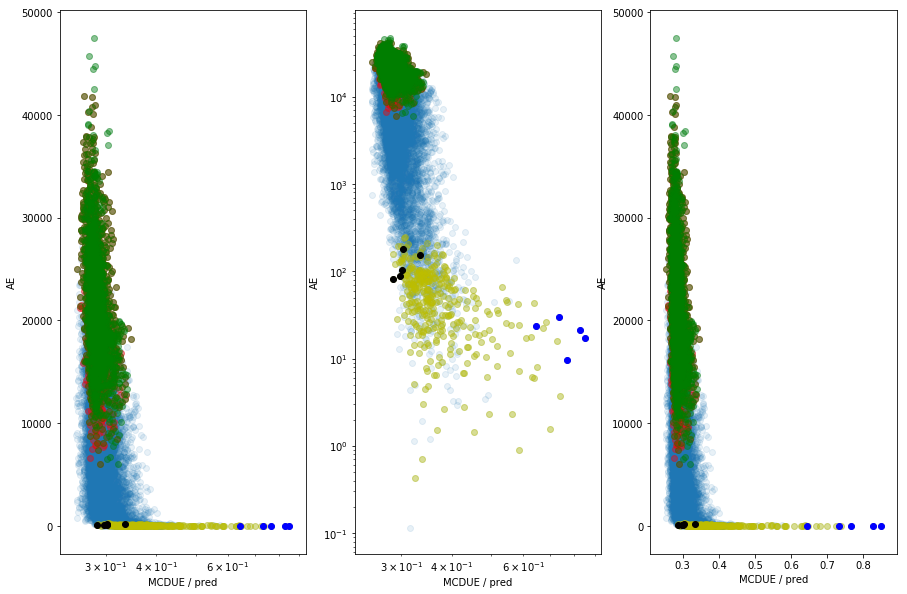

In [16]:
in_sample_ind = np.where(np.max(X_pool, axis=1) <= upper_border // 2)[0].squeeze() # points, which are in the same subset
# argmin_in_sample = 
# as Training points
pred_pool = sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}) # Pool prediction
argmin_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[:5]]
argmax_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[-5:]]
mcdues = get_mcdues_nn(X_pool, sess, y, x, keep_probability_, p = .5, T=100)
##########
mcdues = mcdues / pred_pool.squeeze()
##########
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
for i in [0, 1, 2]:
    if(i==1):
        ax[i].set_yscale('log')
    if(i==0 or i==1):    
        ax[i].set_xscale('log')
    ax[i].set_xlabel('MCDUE / pred')
    ax[i].set_ylabel('AE')
    ax[i].scatter(mcdues, np.abs(y_pool - pred_pool), alpha=0.1) # Pool points
    ax[i].scatter(mcdues[in_sample_ind],  np.abs(y_pool - pred_pool)[in_sample_ind], c='y', alpha=0.4)
    ax[i].scatter(mcdues[indices_dmcdue], np.abs(y_pool - pred_pool)[indices_dmcdue], c='r', alpha=0.4)
    ax[i].scatter(mcdues[indices_mcdue], np.abs(y_pool - pred_pool)[indices_mcdue], c='g', alpha=0.4)
    ax[i].scatter(mcdues[argmin_in_sample],  np.abs(y_pool - pred_pool)[argmin_in_sample], c='b', alpha=1.)
    ax[i].scatter(mcdues[argmax_in_sample],  np.abs(y_pool - pred_pool)[argmax_in_sample], c='k', alpha=1.)

### 2 Thresholding over one of coordinates

In [17]:
def generate_data_outsample_one(size, d, pool_share=0.6, rs=[322228, 1337410, 2033007], upper_border=4):
    
    random_state = rs[0]
    np.random.seed(random_state)
    
    # Pool
    pool_shape = int(size * pool_share)
    randmat = np.random.uniform(size = d * pool_shape).reshape(pool_shape, d) * upper_border # random from [0, 10]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_pool = df.values
    y_pool = targets[:, None]
    
    random_state = rs[1]
    np.random.seed(random_state)
    
    # Test
    train_test_shape = int(size * (1 - pool_share) / 2)
    randmat = np.random.uniform(size = d * train_test_shape).reshape(train_test_shape, d) * upper_border # random from [0, 1]
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_test = df.values
    y_test = targets[:, None]
    
    
    random_state = rs[2]
    np.random.seed(random_state)
    # Train
    train_test_shape = int(size * (1 - pool_share) / 2)
    randmat = np.random.uniform(size = (d - 1) * train_test_shape).reshape(train_test_shape, (d - 1)) * upper_border # random from [0, 1]
    randmat = np.concatenate(((np.random.uniform(size=train_test_shape) * (upper_border // 2))[:, None], randmat), axis=1)
    df = pd.DataFrame(np.concatenate((randmat, rosen(randmat.T).reshape(-1, 1)), axis = 1))
    targets = df.iloc[:, d].values
    df = df.iloc[:, :d]
    X_train = df.values
    y_train = targets[:, None]

    print('Train shapes:', X_train.shape, y_train.shape)
    print('Test shapes:', X_test.shape, y_train.shape)
    print('Pool shapes:', X_pool.shape, y_pool.shape)
    return X_train, y_train, X_test, y_test, X_pool, y_pool

In [18]:
X_train, y_train, X_test, y_test, X_pool, y_pool = generate_data_outsample_one(size, dimensionality, pool_share=0.6, upper_border=4)

Train shapes: (4000, 5) (4000, 1)
Test shapes: (4000, 5) (4000, 1)
Pool shapes: (12000, 5) (12000, 1)


Let us do the similar procedure -- plot AE vs MCDUE, highlight MCDUE, DMCDUE sampled point, and show points which are similar to training dataset (those which have $0\leq x_0 \leq 0.5 *$ upper_bound

In [19]:

lr = 1e-3
keeps_train = [.95]
init_epochs_train = 10000 # Number of epoches for training
batch_size_train = 500 # Training batchsize
ndim = dimensionality
path = './{}/model_onef_{}.ckpt'.format(len(layers), len(layers))

In [20]:
create_model(X_train, y_train, layers, path, lr, keeps_train, init_epochs_train, batch_size_train)
sess, y, y_, x, l2_reg_, keep_probability_, saver, train_step, loss = model_loader(layers,  path, lr)

pos 1
13833.48668464854
4252.364902688813
1770.9037850458078
1829.155540697582
961.7531177672419
701.0037498138513
725.5446188089653
683.6536685950524
707.1309941657428
Early stopping in epoch 800
pos 2
model is saved:  ./4/model_onef_4.ckpt
INFO:tensorflow:Restoring parameters from ./4/model_onef_4.ckpt


In [21]:
from xgboost import XGBRegressor
print('NNs errors', get_errors(sess.run(y, feed_dict= {x: X_train , keep_probability_: 1}), y_train))
reg = XGBRegressor()
reg.fit(X_train, y_train)
np.sqrt(np.mean((reg.predict(X_train) - y_train)**2))
print('XGBoosts errors', get_errors(reg.predict(X_train), y_train))

NNs errors [707.1309941657428, 483.1184024140473, 4373.30981308785]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBoosts errors [697.3494773740343, 540.0928164852547, 3143.711607335561]


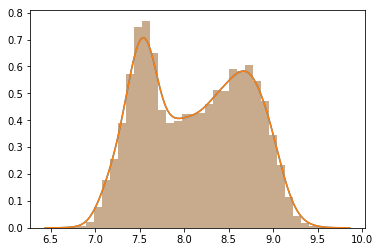

In [22]:
_, _, X_sample, y_sample, indices_dmcdue = DMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample)
_, _, X_sample, y_sample, indices_mcdue = GMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample)

In [23]:
in_sample_ind = np.where(X_pool[:, 0] <= upper_border // 2)[0].squeeze()

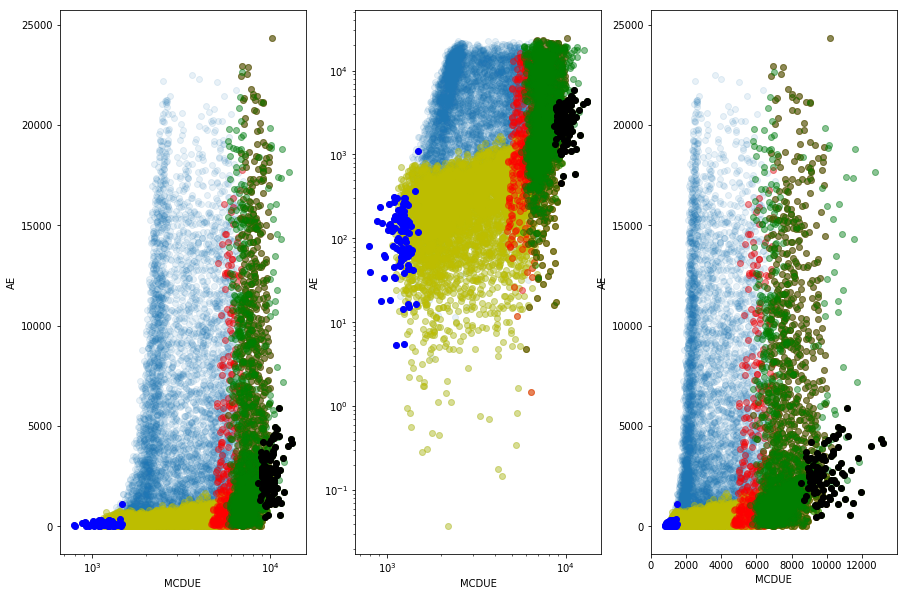

In [24]:
in_sample_ind = np.where(X_pool[:, 0] <= upper_border // 2)[0].squeeze() # points, which are in the same subset
# argmin_in_sample = 
# as Training points
pred_pool = sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}) # Pool prediction
argmin_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[:100]]
argmax_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[-100:]]
mcdues = get_mcdues_nn(X_pool, sess, y, x, keep_probability_, p = .5, T=100)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
for i in [0, 1, 2]:
    if(i==1):
        ax[i].set_yscale('log')
    if(i==0 or i==1):    
        ax[i].set_xscale('log')
    ax[i].set_xlabel('MCDUE')
    ax[i].set_ylabel('AE')
    ax[i].scatter(mcdues, np.abs(y_pool - pred_pool), alpha=0.1) # Pool points
    ax[i].scatter(mcdues[in_sample_ind],  np.abs(y_pool - pred_pool)[in_sample_ind], c='y', alpha=0.4)
    ax[i].scatter(mcdues[indices_dmcdue], np.abs(y_pool - pred_pool)[indices_dmcdue], c='r', alpha=0.4)
    ax[i].scatter(mcdues[indices_mcdue], np.abs(y_pool - pred_pool)[indices_mcdue], c='g', alpha=0.4)
    ax[i].scatter(mcdues[argmin_in_sample],  np.abs(y_pool - pred_pool)[argmin_in_sample], c='b', alpha=1.)
    ax[i].scatter(mcdues[argmax_in_sample],  np.abs(y_pool - pred_pool)[argmax_in_sample], c='k', alpha=1.)

Yellow -- points of Pool which are similar to Train points

Dark Blue -- 100 points with least MCDUE on Yellow points

Blackish -- 100 points with top MCDUE on Yellow points

Red - DCDUE

Green - MCDUE

### Normalized

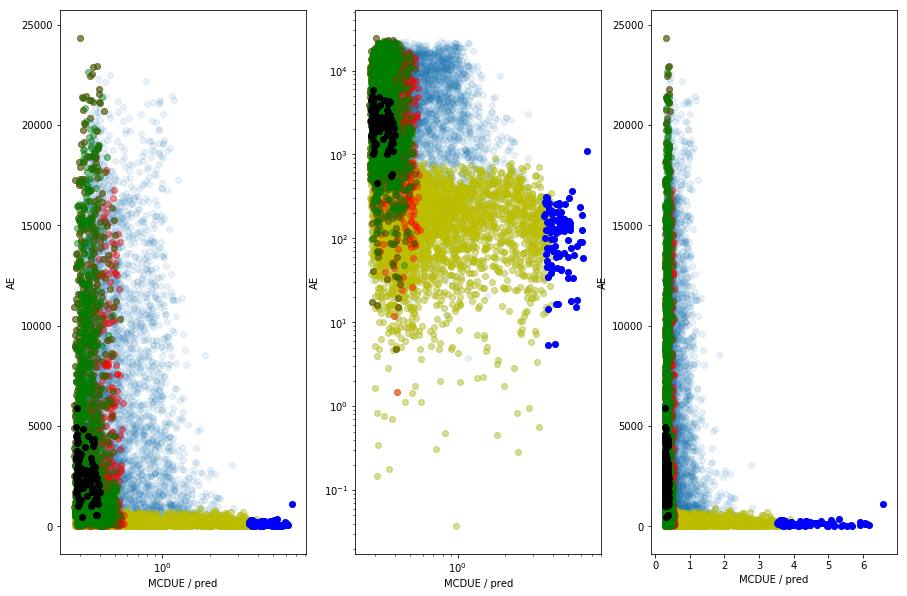

In [25]:
in_sample_ind = np.where(X_pool[:, 0] <= upper_border // 2)[0].squeeze() # points, which are in the same subset
# argmin_in_sample = 
# as Training points
pred_pool = sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}) # Pool prediction
argmin_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[:100]]
argmax_in_sample = in_sample_ind[np.argsort(pred_pool[in_sample_ind].squeeze())[-100:]]
mcdues = get_mcdues_nn(X_pool, sess, y, x, keep_probability_, p = .5, T=100)
########
mcdues = mcdues / pred_pool.squeeze()
########
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
for i in [0, 1, 2]:
    if(i==1):
        ax[i].set_yscale('log')
    if(i==0 or i==1):    
        ax[i].set_xscale('log')
    ax[i].set_xlabel('MCDUE / pred')
    ax[i].set_ylabel('AE')
    ax[i].scatter(mcdues, np.abs(y_pool - pred_pool), alpha=0.1) # Pool points
    ax[i].scatter(mcdues[in_sample_ind],  np.abs(y_pool - pred_pool)[in_sample_ind], c='y', alpha=0.4)
    ax[i].scatter(mcdues[indices_dmcdue], np.abs(y_pool - pred_pool)[indices_dmcdue], c='r', alpha=0.4)
    ax[i].scatter(mcdues[indices_mcdue], np.abs(y_pool - pred_pool)[indices_mcdue], c='g', alpha=0.4)
    ax[i].scatter(mcdues[argmin_in_sample],  np.abs(y_pool - pred_pool)[argmin_in_sample], c='b', alpha=1.)
    ax[i].scatter(mcdues[argmax_in_sample],  np.abs(y_pool - pred_pool)[argmax_in_sample], c='k', alpha=1.)

### 3. Without restrictions on train dataset

In [26]:
X_train, y_train, X_test, y_test, X_pool, y_pool = generate_data(size, dimensionality, pool_share=0.6, upper_border=4)

Train shapes: (4000, 5) (4000, 1)
Test shapes: (4000, 5) (4000, 1)
Pool shapes: (12000, 5) (12000, 1)


In [27]:

lr = 1e-3
keeps_train = [.95]
init_epochs_train = 10000 # Number of epoches for training
batch_size_train = 1000 # Training batchsize
ndim = dimensionality
path = './{}/model_ord_{}.ckpt'.format(len(layers), len(layers))

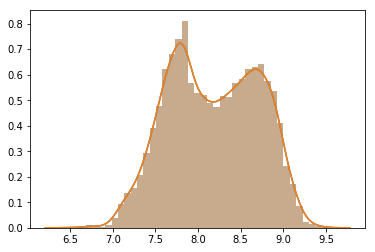

In [28]:
_, _, X_sample, y_sample, indices_dmcdue = DMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample)
_, _, X_sample, y_sample, indices_mcdue = GMCDUE_sampling(X_pool, y_pool, sess, y, x, keep_probability_, points_to_sample)

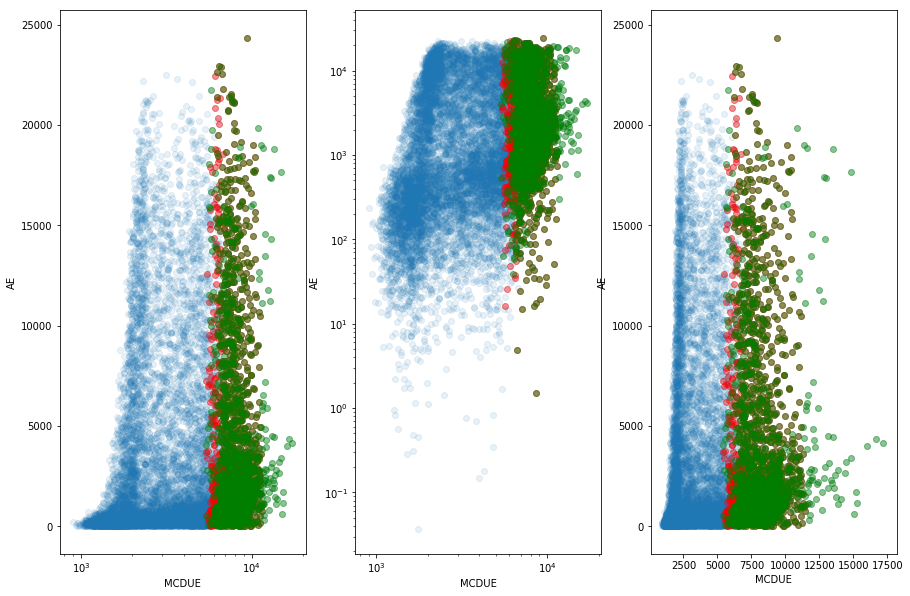

In [29]:
pred_pool = sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}) # Pool prediction
mcdues = get_mcdues_nn(X_pool, sess, y, x, keep_probability_, p = .5, T=100)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
for i in [0, 1, 2]:
    if(i==1):
        ax[i].set_yscale('log')
    if(i==0 or i==1):    
        ax[i].set_xscale('log')
    ax[i].set_xlabel('MCDUE')
    ax[i].set_ylabel('AE')
    ax[i].scatter(mcdues, np.abs(y_pool - pred_pool), alpha=0.1) # Pool points
    ax[i].scatter(mcdues[indices_dmcdue], np.abs(y_pool - pred_pool)[indices_dmcdue], c='r', alpha=0.4)
    ax[i].scatter(mcdues[indices_mcdue], np.abs(y_pool - pred_pool)[indices_mcdue], c='g', alpha=0.4)

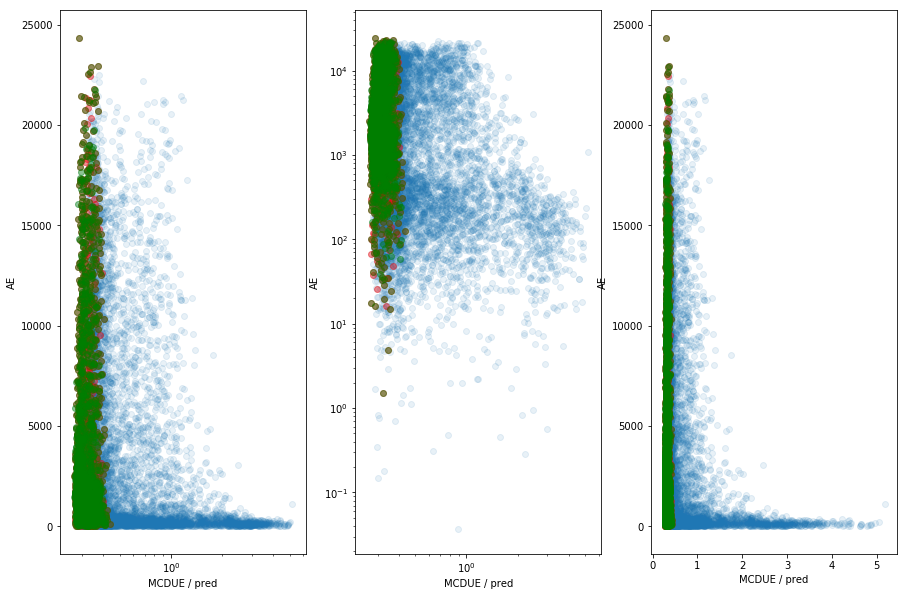

In [30]:
pred_pool = sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}) # Pool prediction
mcdues = get_mcdues_nn(X_pool, sess, y, x, keep_probability_, p = .5, T=100)
mcdues = mcdues / pred_pool.squeeze()
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
for i in [0, 1, 2]:
    if(i==1):
        ax[i].set_yscale('log')
    if(i==0 or i==1):    
        ax[i].set_xscale('log')
    ax[i].set_xlabel('MCDUE / pred')
    ax[i].set_ylabel('AE')
    ax[i].scatter(mcdues, np.abs(y_pool - pred_pool), alpha=0.1) # Pool points
    ax[i].scatter(mcdues[indices_dmcdue], np.abs(y_pool - pred_pool)[indices_dmcdue], c='r', alpha=0.4)
    ax[i].scatter(mcdues[indices_mcdue], np.abs(y_pool - pred_pool)[indices_mcdue], c='g', alpha=0.4)

Text(0, 0.5, 'AE')

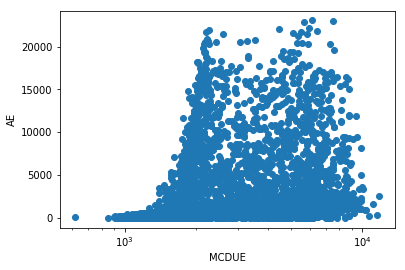

In [31]:
pred_test = sess.run(y, feed_dict= {x: X_test , keep_probability_: 1})
mcdues = get_mcdues_nn(X_test, sess, y, x, keep_probability_, p = .5, T=100)
plt.scatter(mcdues, np.abs(y_test - pred_test))
# plt.scatter(mcdues[out_sample_ind],  np.abs(y_test - pred_test)[indices_dmcdue], c='r', alpha=0.6)
# plt.scatter(mcdues[indices_dmcdue], np.abs(y_test - pred_test)[indices_dmcdue], c='r', alpha=0.6)
# plt.scatter(mcdues[indices_mcdue], np.abs(y_test - pred_test)[indices_mcdue], c='g', alpha=0.6)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('MCDUE')
plt.ylabel('AE')

Text(0, 0.5, 'AE')

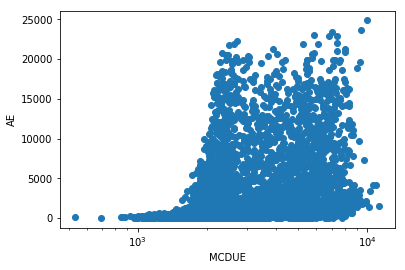

In [32]:
pred_train = sess.run(y, feed_dict= {x: X_train , keep_probability_: 1})
mcdues = get_mcdues_nn(X_train, sess, y, x, keep_probability_, p = .5, T=100)
plt.scatter(mcdues, np.abs(y_train - pred_train))
# plt.scatter(mcdues[out_sample_ind],  np.abs(y_test - pred_test)[indices_dmcdue], c='r', alpha=0.6)
# plt.scatter(mcdues[indices_dmcdue], np.abs(y_test - pred_test)[indices_dmcdue], c='r', alpha=0.6)
# plt.scatter(mcdues[indices_mcdue], np.abs(y_test - pred_test)[indices_mcdue], c='g', alpha=0.6)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('MCDUE')
plt.ylabel('AE')

In [33]:
np.max(pred_pool)

43568.727

In [34]:
np.where(np.max(X_pool, axis=1) <= upper_border // 2)[0]

array([   35,   107,   121,   128,   139,   179,   192,   204,   245,
         275,   296,   309,   435,   442,   453,   478,   485,   488,
         504,   590,   605,   647,   673,   715,   764,   896,   918,
         926,   936,   949,   954,   992,  1053,  1055,  1061,  1065,
        1067,  1084,  1118,  1151,  1153,  1156,  1162,  1216,  1252,
        1331,  1332,  1336,  1403,  1510,  1539,  1560,  1589,  1600,
        1629,  1696,  1766,  1775,  1783,  1857,  1859,  1870,  1874,
        1879,  1901,  2001,  2058,  2069,  2097,  2133,  2139,  2152,
        2224,  2356,  2357,  2477,  2512,  2517,  2518,  2524,  2596,
        2622,  2682,  2740,  2772,  2778,  2781,  2796,  2891,  2932,
        2995,  3005,  3017,  3019,  3126,  3163,  3192,  3197,  3201,
        3208,  3209,  3217,  3240,  3244,  3255,  3338,  3384,  3415,
        3443,  3506,  3512,  3576,  3590,  3611,  3622,  3630,  3658,
        3805,  3853,  3868,  3880,  3904,  3918,  3942,  3986,  4115,
        4133,  4167,

In [35]:
np.max(np.abs(y_pool - pred_pool))

24338.981077869037

In [36]:
from xgboost import XGBRegressor


In [37]:
print('NNs errors', get_errors(sess.run(y, feed_dict= {x: X_train , keep_probability_: 1}), y_train))
reg = XGBRegressor()
reg.fit(X_train, y_train)
np.sqrt(np.mean((reg.predict(X_train) - y_train)**2))
print('XGBoosts errors', get_errors(reg.predict(X_train), y_train))

NNs errors [6065.142860524198, 3571.34335472108, 24867.642279855885]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBoosts errors [898.6796235261024, 692.5784891111633, 4084.2263641964746]


In [38]:
print('NNs errors', get_errors(sess.run(y, feed_dict= {x: X_pool , keep_probability_: 1}), y_pool))
reg = XGBRegressor()
reg.fit(X_train, y_train)
np.sqrt(np.mean((reg.predict(X_pool) - y_pool)**2))
print('XGBoosts errors', get_errors(reg.predict(X_pool), y_pool))

NNs errors [5845.550559031907, 3431.6406138807924, 24338.981077869037]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


XGBoosts errors [1159.0888334835965, 872.4705538215314, 8286.884648986423]
